In [1]:
from dataset import StockDataset, normalize_stock
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from StockPredictorLSTM import StockPredictorLSTM
import torch
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import seaborn as sns  # for coloring 

# set style of graphs
plt.style.use('seaborn')
from pylab import rcParams
plt.rcParams['figure.dpi'] = 100

In [3]:
df = pd.read_csv('../../stock/SAN.csv', parse_dates=True, index_col='Date').dropna(how='any')
X_train, X_test = train_test_split(df, test_size=0.1, shuffle=False)

In [4]:
predictor = StockPredictorLSTM(hidden_dim=64, num_layers=2)
predictor.fit(X_train, batch_size=32, epochs=10)

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]
2022-12-19 08:37:41,059 DEBUG    pid:6805 StockPredictorLSTM:217:saveModel Saved model params to ../../models/LSTM/LSTM_2022-12-19_08.37.30.state
2022-12-19 08:37:41,061 INFO     pid:6805 StockPredictorLSTM:236:saveModel SHA1: 65b941ba5f31f0d175a75238532f773c7752ae86


In [5]:
today = pd.DataFrame({
                    "Date": pd.to_datetime("2022-12-16"),
                    "Open": [2.6845],
                    "High": [2.7350	],
                    "Low": [2.6670],
                    "Volume": [92000000]
}).set_index("Date")

forecast = pd.concat([df.iloc[-29:], today])

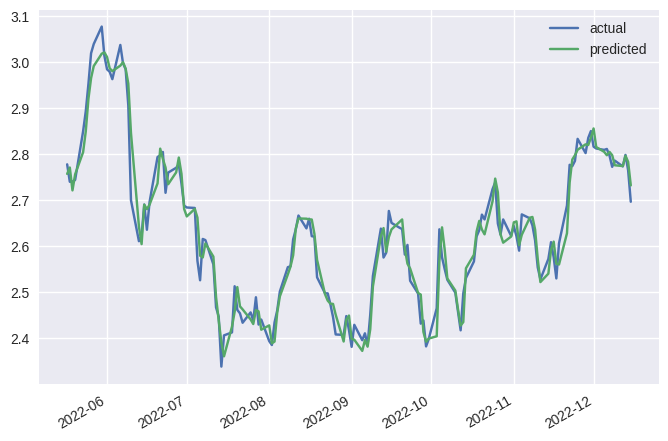

In [6]:
y_pred = predictor.predict(X_test, plot=True)

In [8]:
y_pred[-1]

tensor(2.7322)